Notebook to study the intervals at which datasets are read by CMS users (using crab as that is the source of data popularity this study uses).

The analysis steps are to:
 - Load previously cached popularity information. This consists of dataset name and days on which it was read (and how many files were read)
 - Load previously cached dbs information. This consists of dataset name and dataset size (and other information) for all datasets known to dbs. This is part of the hdfs monitoring information we keep.
 - For datasets read more than once, compute the number of days between reads
 - Histogram these results (Entries vs days between reads)
 - Histogram these results weighted by dataset size.

In [32]:
import gzip
import numpy
myJInput=''
for line in gzip.open('popDaily.txt.gz'):
    myJInput += line

import json    
myJ=json.loads(myJInput)

In [33]:
datasets={}
dates=myJ.keys()

minD=None
maxD=None
i=0
for i,d in enumerate(dates):
    npD=numpy.datetime64(d)
    if minD==None or minD>npD:
        minD=npD
    if maxD==None or maxD<npD:
        maxD=npD
print "first date",minD,"last date",maxD

first date 2016-01-01 last date 2018-10-11


In [35]:
for i,d in enumerate(dates):
    npD=numpy.datetime64(d)
#    if i%100==0:
#        print i,d
    records = myJ[d]['DATA']
    for record in records:
        dataset=record['COLLNAME']
        ending=dataset.split('/')[-1]
        if 'AOD' not in ending: continue
        nacc=record["NACC"]
        if dataset not in datasets:
            datasets[dataset]={}
        datasets[dataset][npD]=nacc
        
print "number of datasets in popularity info",len(datasets)

#keys=datasets.keys()
#for key in keys:
#    if '09May2018' in key: print key
#print datasets['/BTagCSV/Run2017F-09May2018-v1/AOD']
myJ=None

number of datasets in popularity info 40419


In [19]:
import gzip
import csv

dbs_info={}
dbs_columns={}
with gzip.open('dbs_events_181022.csv.gz') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    n=0
    for row in reader:
        if n==0:
            for i,a in enumerate(row[1:]):
                dbs_columns[a]=i
        else:        
            dbs_info[row[0]]=tuple(row[1:])
        n=n+1
print("Done reading dbs info")
#print dbs_columns

Done reading dbs info


In [20]:
#get an array with all the datasets I found in the popularity
datasetList=datasets.keys()

In [21]:
import numpy
allDeltas=numpy.array([])
allSizes=numpy.array([])
col_size=dbs_columns['size']
nKeyError=0
errors=[]
nKeyOk=0
datasetsReadOnce=0
for i in range(len(datasetList)):
    t=numpy.array(datasets[datasetList[i]].keys())
    t.sort()
    if len(t)>1:
        allDeltas=numpy.concatenate((allDeltas, (t[1:]-t[:-1])/numpy.timedelta64(1,'D')), axis=None)
        if datasetList[i] in dbs_info:
            nKeyOk+=1
            allSizes=numpy.concatenate((allSizes, 
                                       (float(dbs_info[datasetList[i]][col_size])/1024./1024./1024.)*numpy.ones(len(t)-1)), 
                                       axis=None)
        else:
            nKeyError+=1
            errors.append(datasetList[i])
            allSizes=numpy.concatenate( (allSizes,numpy.zeros(len(t)-1)), axis=None)
    else: 
        if len(t)==1:
            datasetsReadOnce+=1
print "Missing datasets",nKeyError,"Total datasets",nKeyOk,"Datasets read once",datasetsReadOnce
#uncomment this to get the list of datasets not in the dbs dump
print errors[0:10]
        

Missing datasets 0 Total datasets 30688 Datasets read once 9731
[]


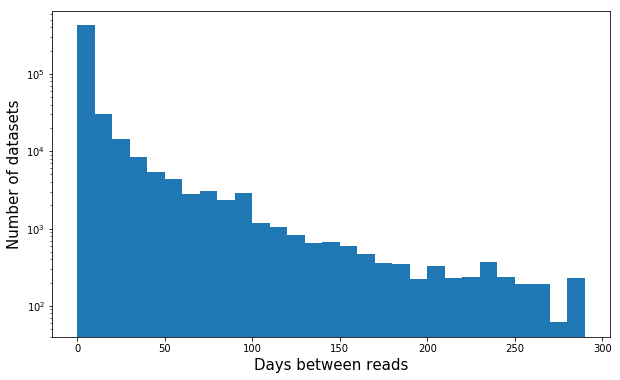

In [22]:
#Plot the number of datasets that you would need to recall given a threshold for 
#the deletion policy
#NOTE: this plot can not be turned into an indication of how many data sets would need to 
#be on disk given that some data sets are read just once (or 0) and thus not included
#From above you see that the number of datasets with just one read is big
#I think we need to include these datasets somehow, but I haven't decided how 
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 10, 6
pylab.hist(allDeltas,numpy.arange(0,300,10),log=True)
d=pylab.xlabel('Days between reads',fontsize=15)
d=pylab.ylabel('Number of datasets',fontsize=15)


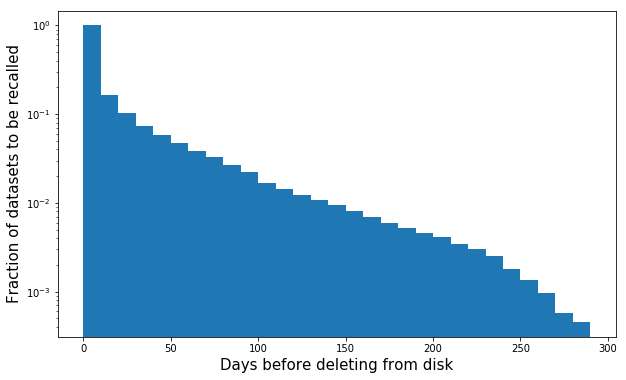

In [23]:
#and now the cumulative plot (the one to look at)
pylab.hist(allDeltas,numpy.arange(0,300,10),log=True,density=True,cumulative=-1)
d=pylab.xlabel('Days before deleting from disk',fontsize=15)
d=pylab.ylabel('Fraction of datasets to be recalled',fontsize=15)

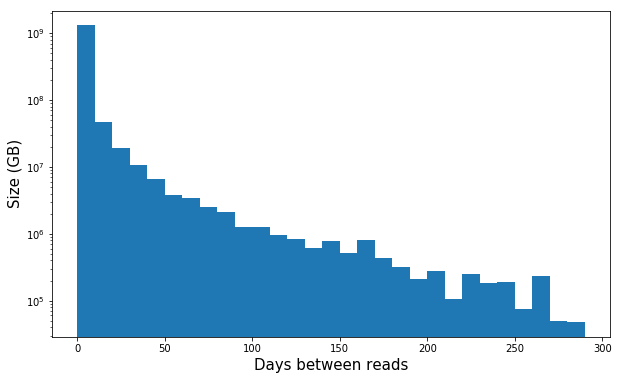

In [24]:
#now the raw distribution weighted by dataset size
pylab.hist(allDeltas,numpy.arange(0,300,10),weights=allSizes,log=True)
d=pylab.xlabel('Days between reads',fontsize=15)
d=pylab.ylabel('Size (GB)',fontsize=15)

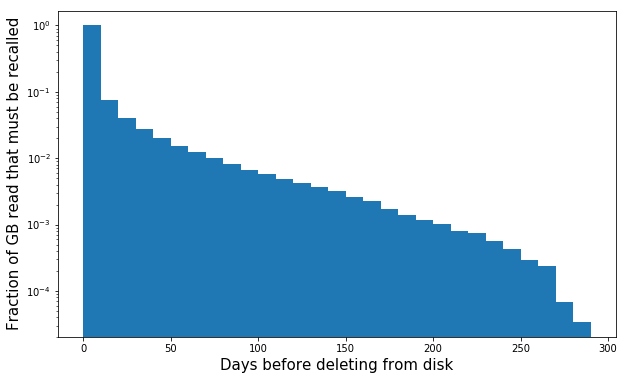

In [25]:
#and now the cumulative plot (the one to look at)
pylab.hist(allDeltas,numpy.arange(0,300,10),weights=allSizes,log=True,density=True,cumulative=-1)
d=pylab.xlabel('Days before deleting from disk',fontsize=15)
d=pylab.ylabel('Fraction of GB read that must be recalled',fontsize=15)

In [55]:
maxPlus1M=maxD+numpy.timedelta64(1,'M').astype(numpy.dtype('m8[D]'))
months=numpy.arange(numpy.datetime64('-'.join(str(minD).split('-')[0:2])),numpy.datetime64('-'.join(str(maxPlus1M).split('-')[0:2])))
month_min=minD.astype(numpy.dtype('<M8[M]'))
n_months=len(months)
print month_min
print months
campaigns={}
campaign_hists_mini={}
campaign_hists_aod={}
campaign_hists_other={}
camp_column=dbs_columns['era']
for d in datasets:
    camp=dbs_info[d][camp_column]
    ending=d.split('/')[-1]
    if 'CMSSW_' in camp: continue
    if 'Run20' in camp and len(camp)==8: camp=camp[:-1]
    campaigns[camp]=campaigns.get(camp,0)+1
    if camp not in campaign_hists_aod:
        campaign_hists_aod[camp]=numpy.zeros(n_months,int)
        campaign_hists_mini[camp]=numpy.zeros(n_months,int)
        campaign_hists_other[camp]=numpy.zeros(n_months,int)
    for dat in datasets[d]:
        if 'MINIAOD' in ending:
            campaign_hists_mini[camp][int((dat.astype(numpy.dtype('<M8[M]'))-month_min)/numpy.timedelta64(1,'M'))]+=1
        else:
            if 'AOD' == ending:
                campaign_hists_aod[camp][int((dat.astype(numpy.dtype('<M8[M]'))-month_min)/numpy.timedelta64(1,'M'))]+=1
            else:
                campaign_hists_other[camp][int((dat.astype(numpy.dtype('<M8[M]'))-month_min)/numpy.timedelta64(1,'M'))]+=1
for c in campaigns:
    print c,campaigns[c],campaign_hists_mini[c]


2016-01
['2016-01' '2016-02' '2016-03' '2016-04' '2016-05' '2016-06' '2016-07'
 '2016-08' '2016-09' '2016-10' '2016-11' '2016-12' '2017-01' '2017-02'
 '2017-03' '2017-04' '2017-05' '2017-06' '2017-07' '2017-08' '2017-09'
 '2017-10' '2017-11' '2017-12' '2018-01' '2018-02' '2018-03' '2018-04'
 '2018-05' '2018-06' '2018-07' '2018-08' '2018-09' '2018-10']
HINPbPbWinter16DR 261 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
RunIIFall17DRStdmix 38 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
PARun2016A 1 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Run2016 1543 [   0    0    0    0  281  515 1027 1361 1388 2191 3441 2094 2696 3623
 2985 2270 2361 2469 2275 2338 2133 2694 2278 1804 2151 2191 1727 1964
 1946 2372 1394 1827 1298  626]
PhaseIITDRFall17MiniAOD 306 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    5  718  802 1000  788  257  153
   88  413  104  421 

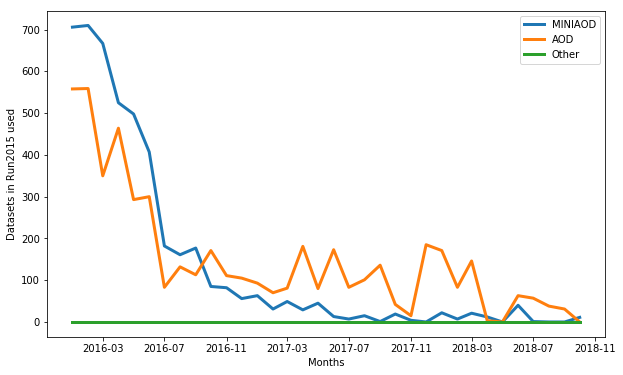

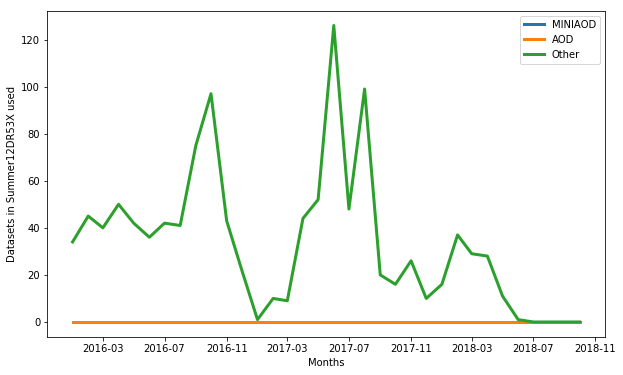

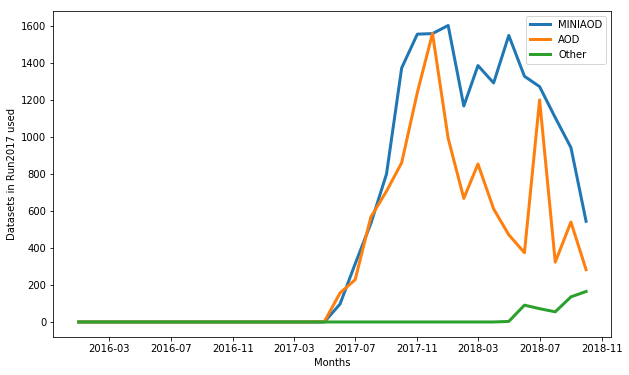

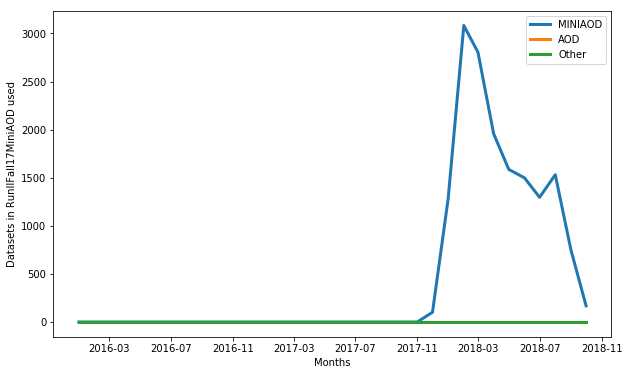

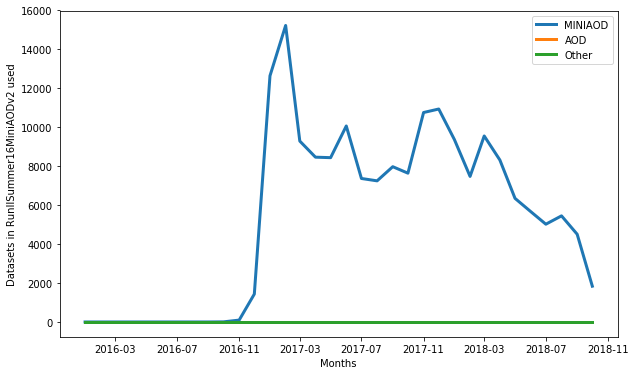

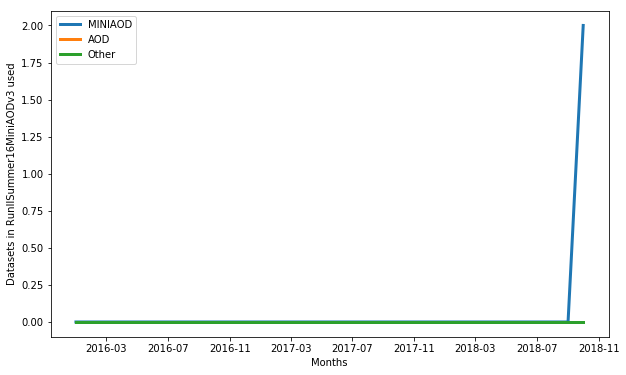

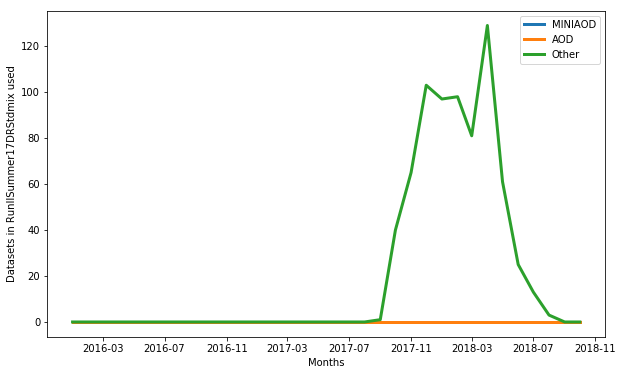

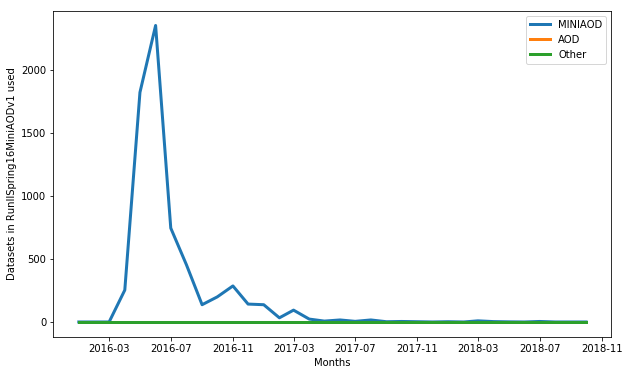

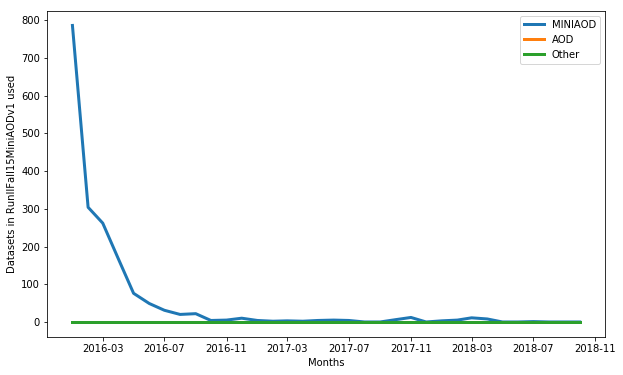

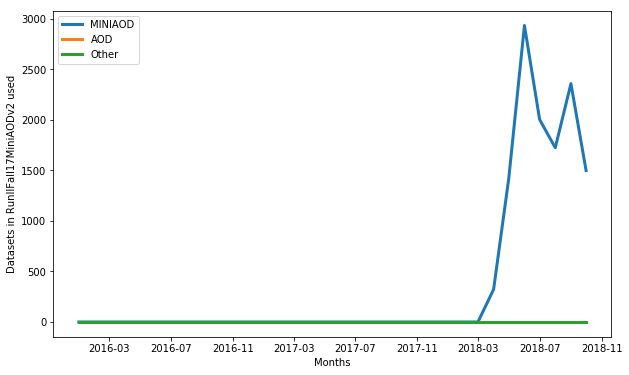

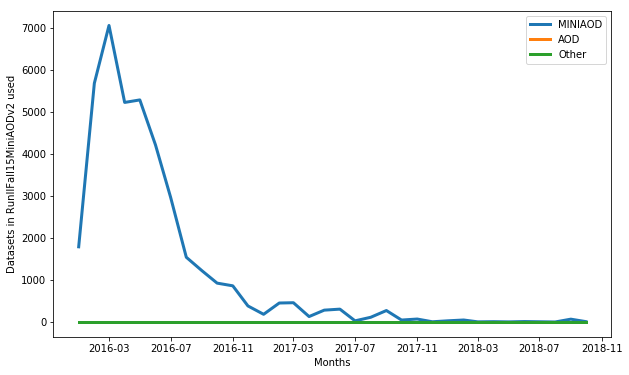

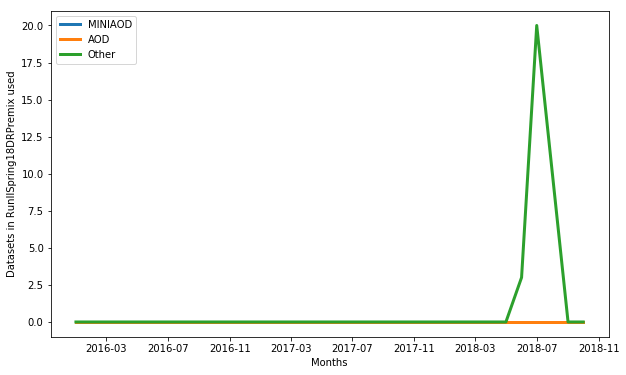

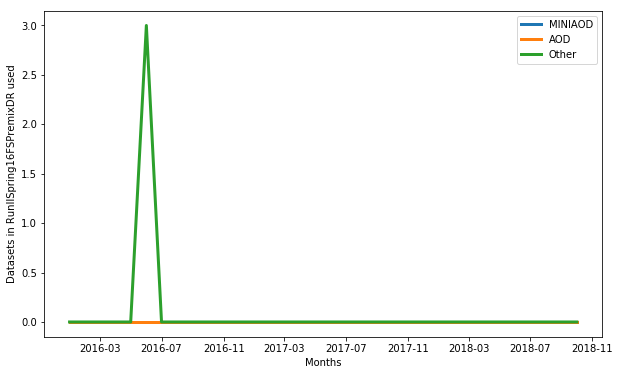

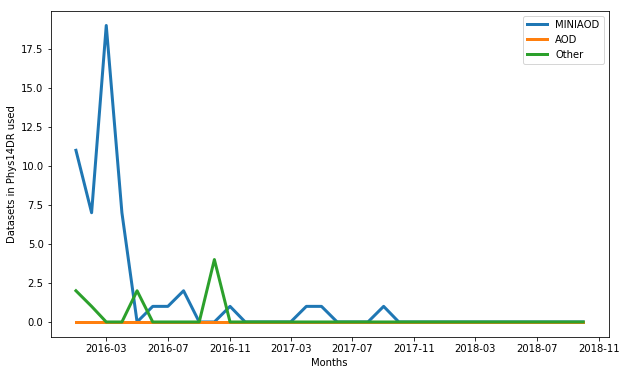

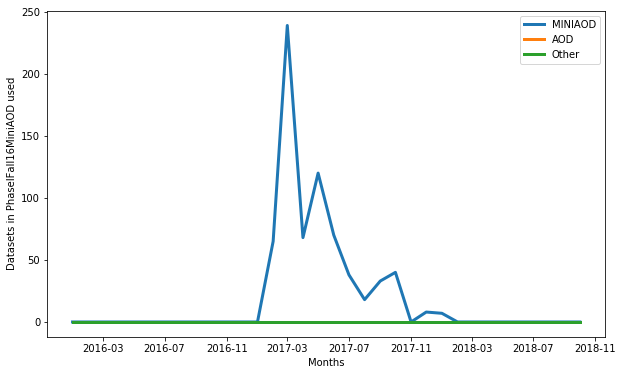

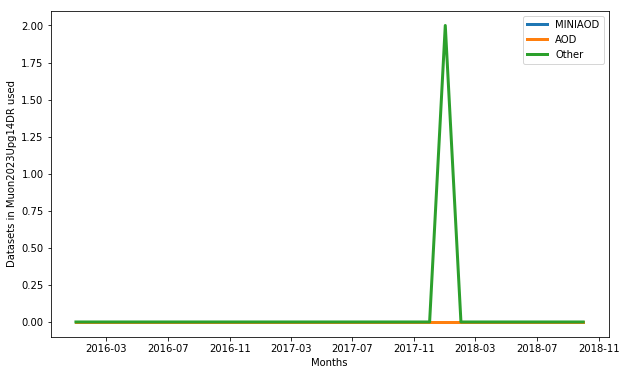

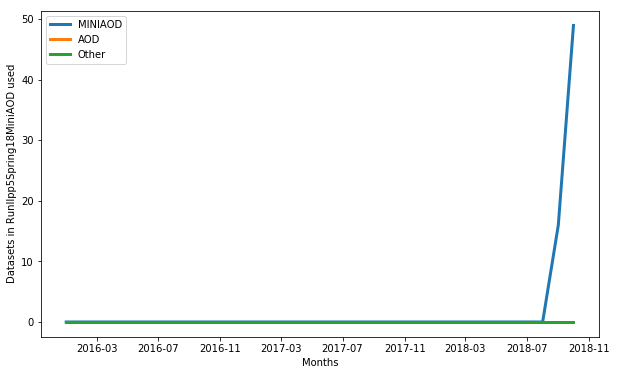

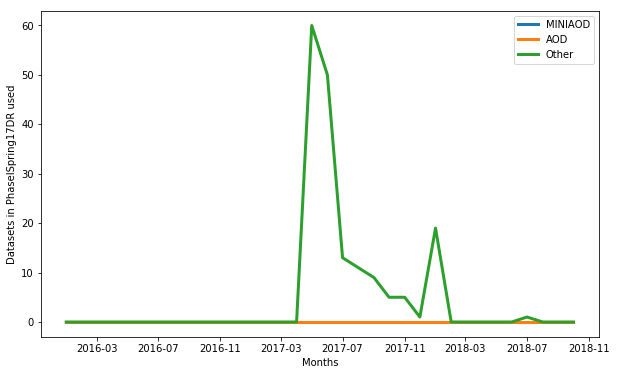

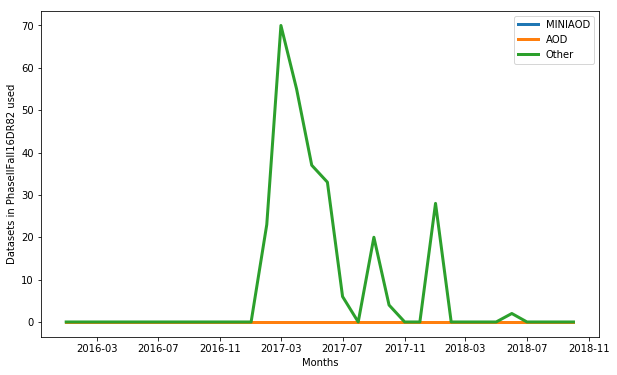

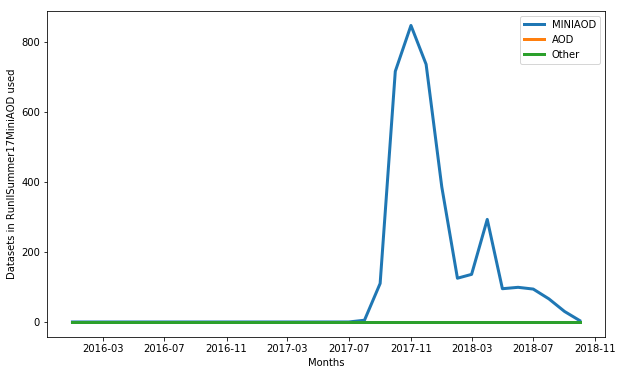

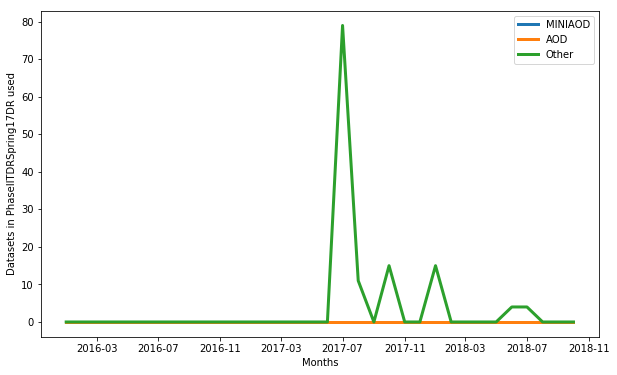

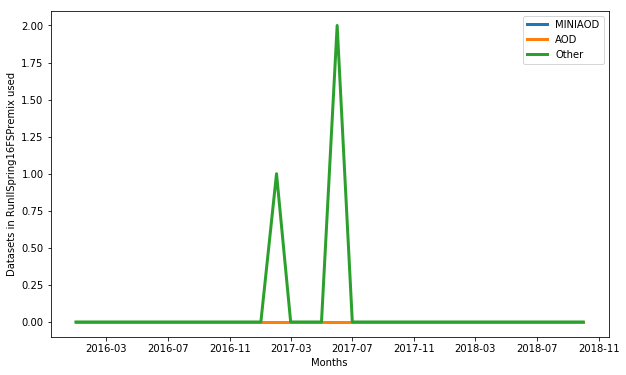

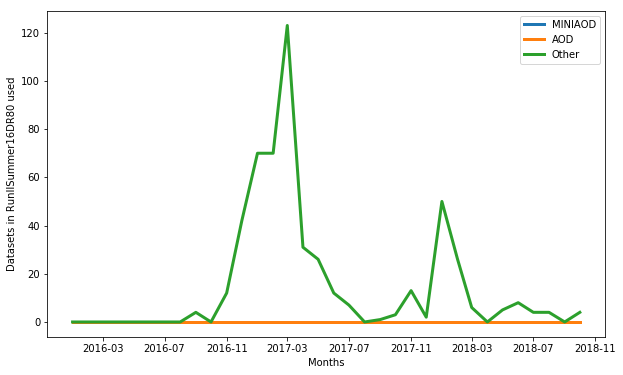

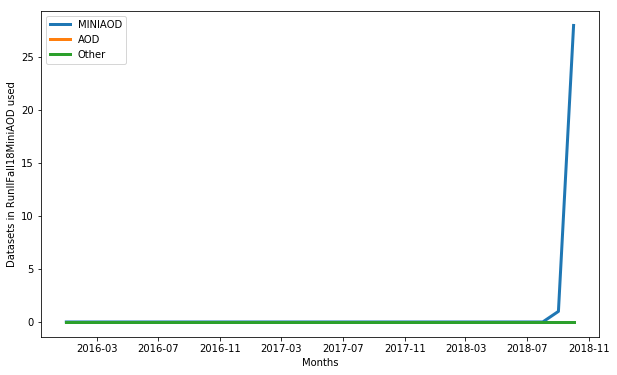

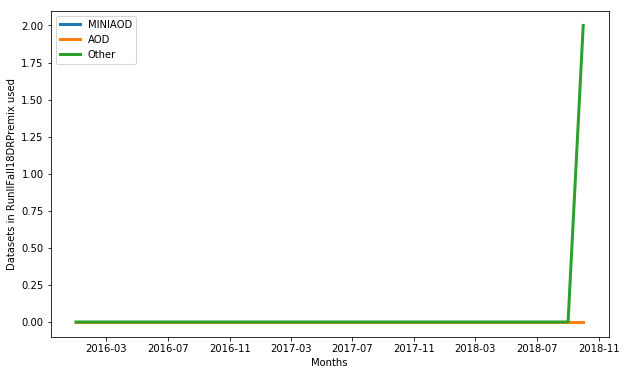

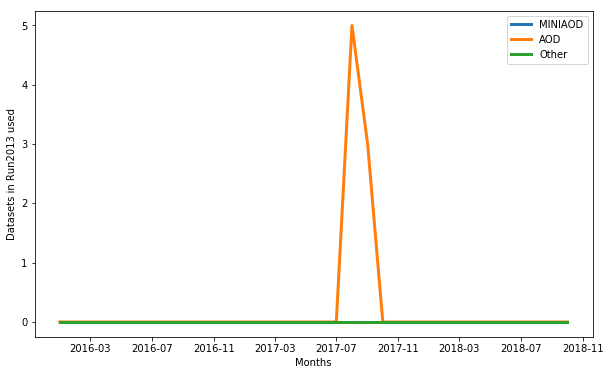

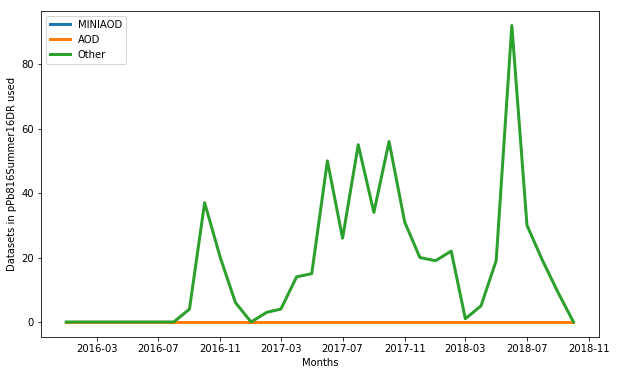

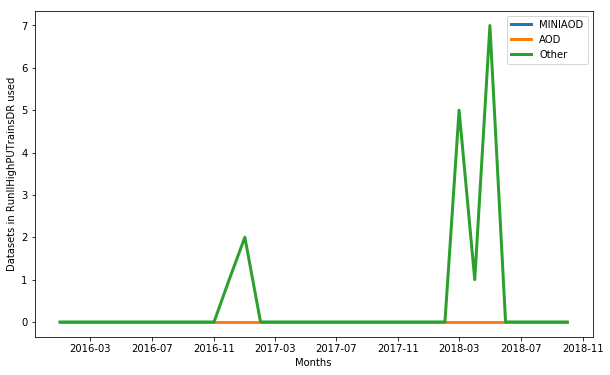

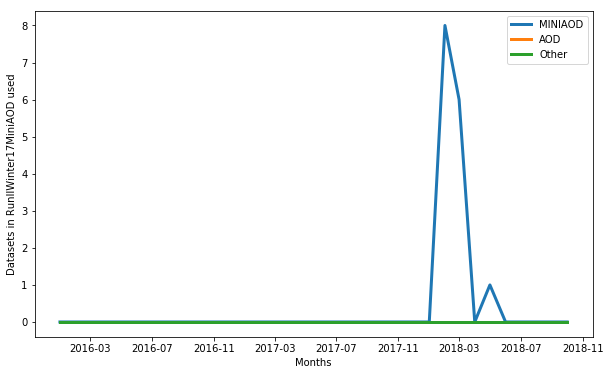

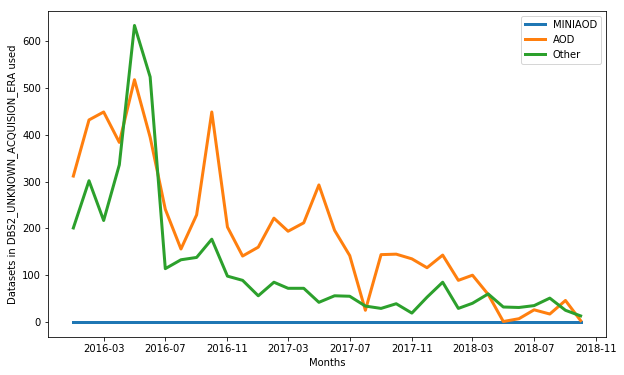

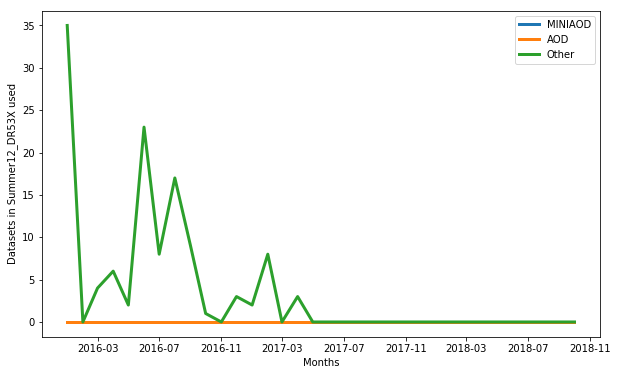

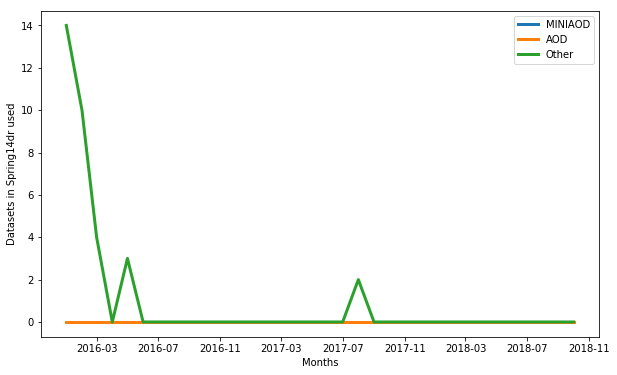

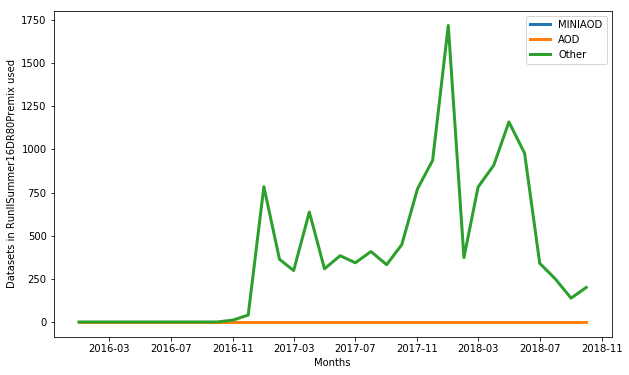

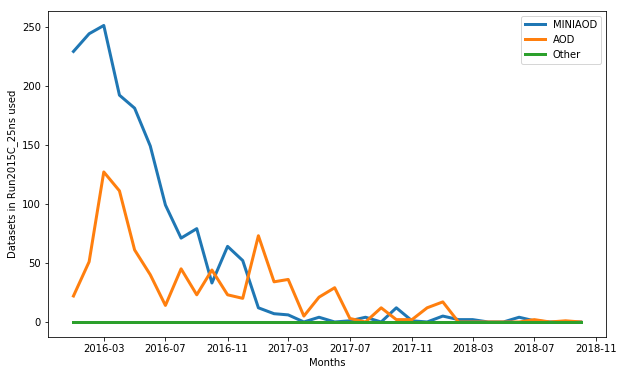

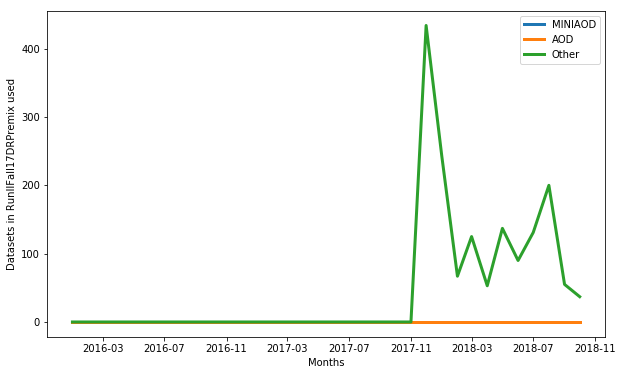

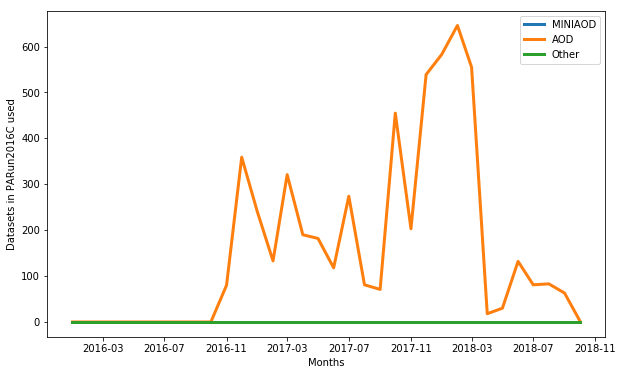

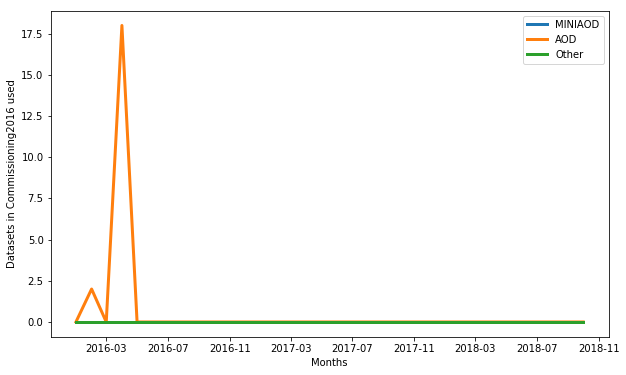

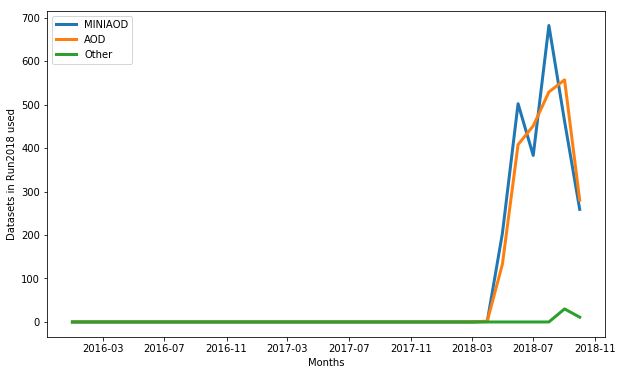

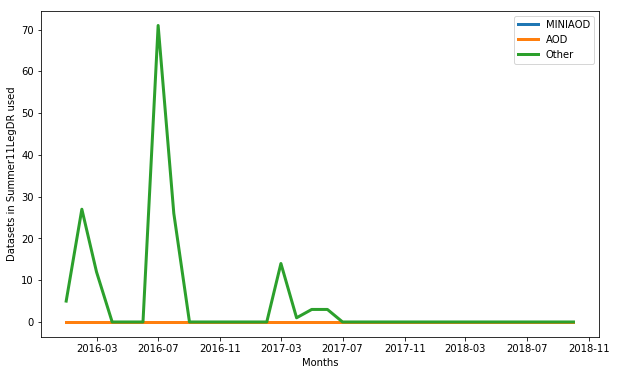

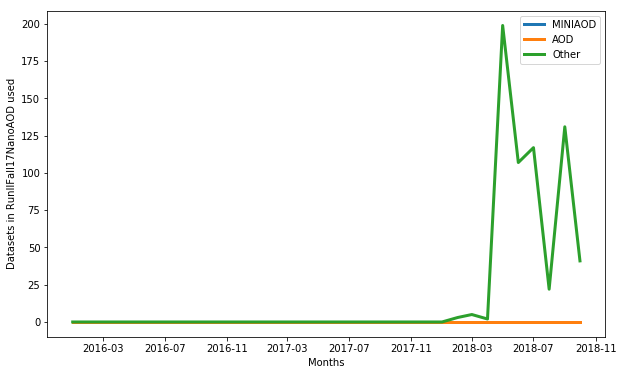

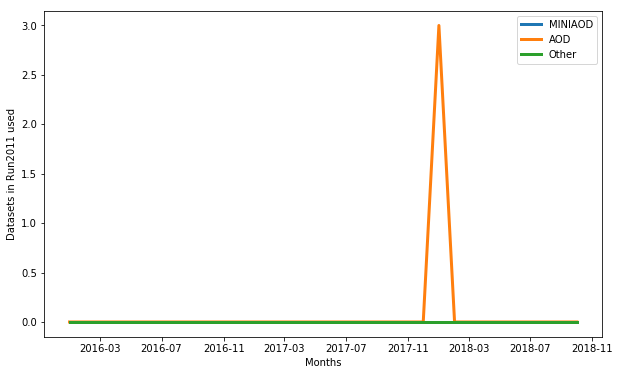

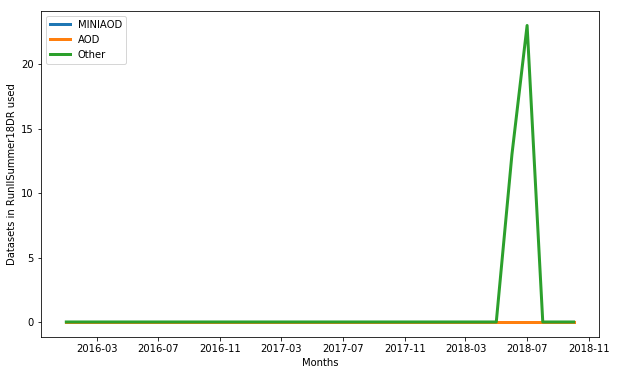

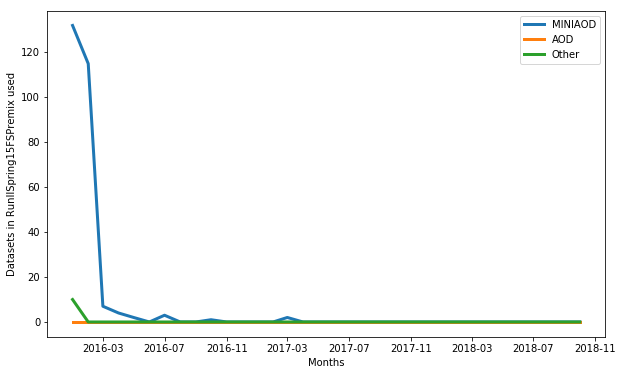

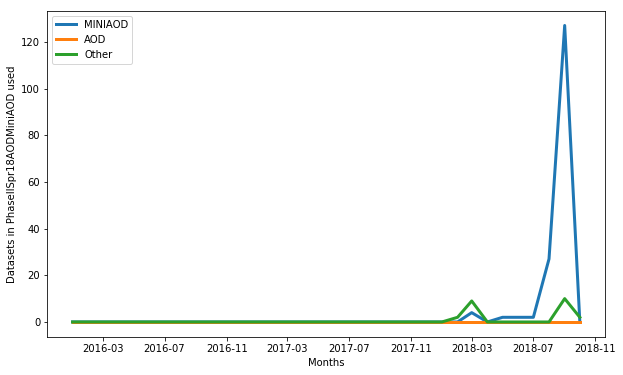

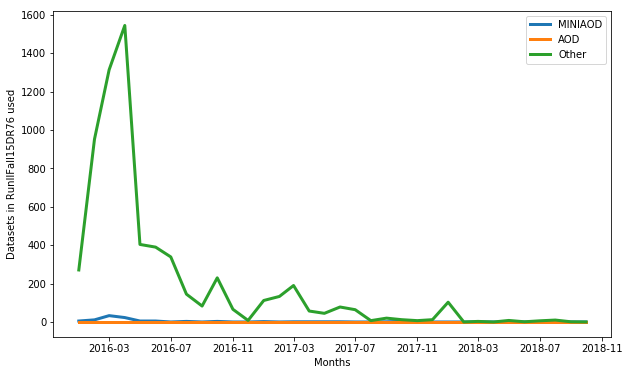

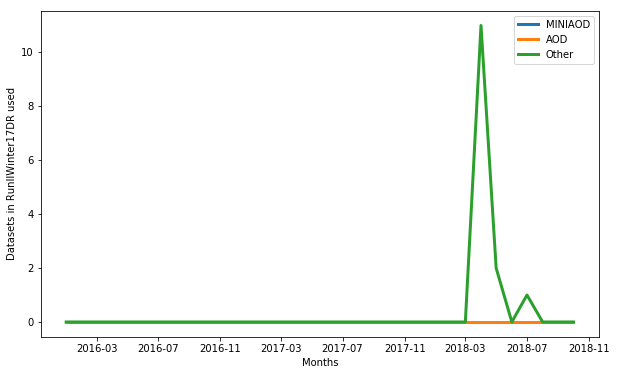

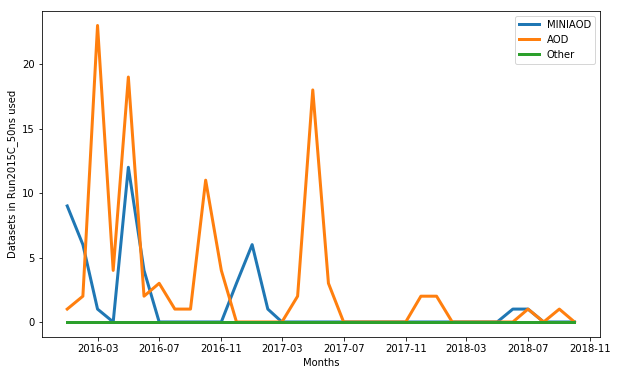

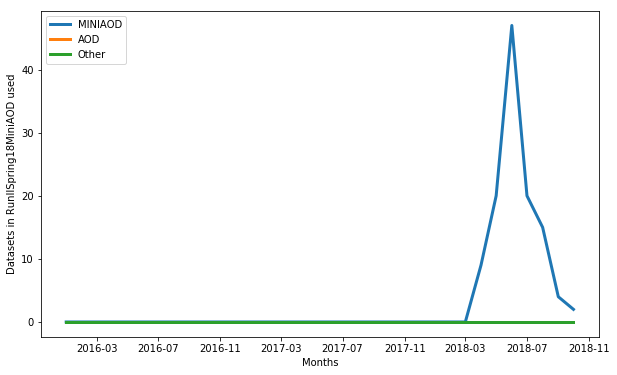

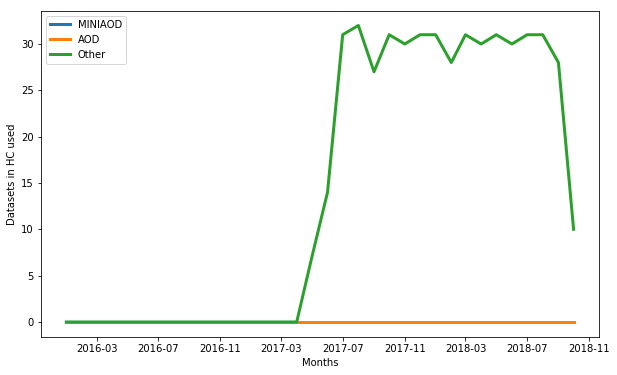

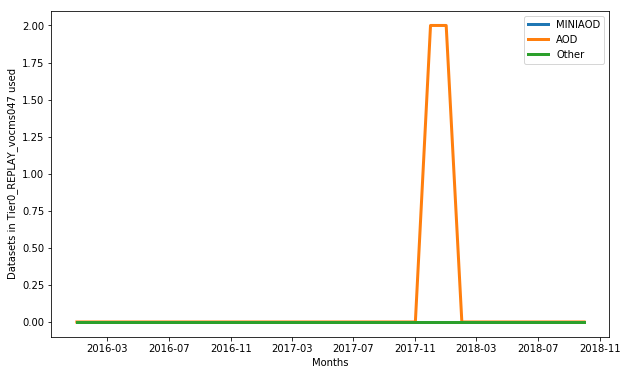

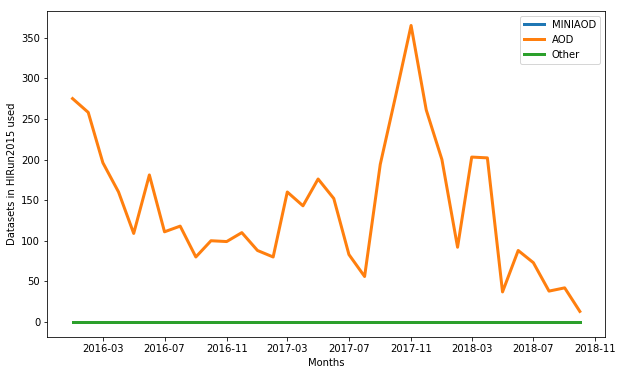

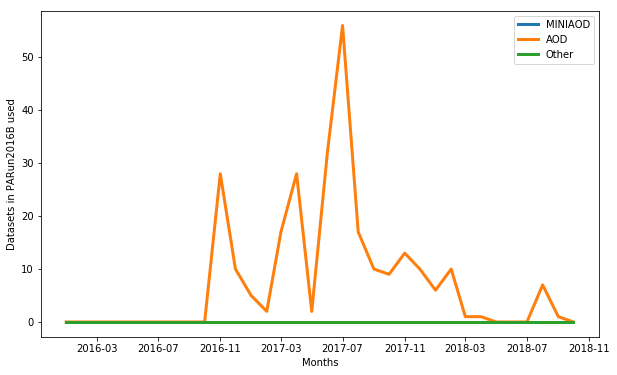

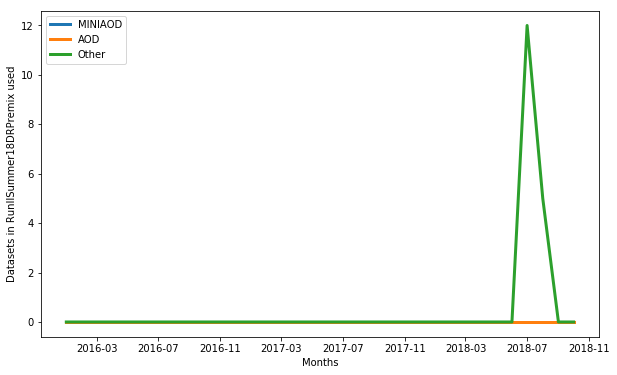

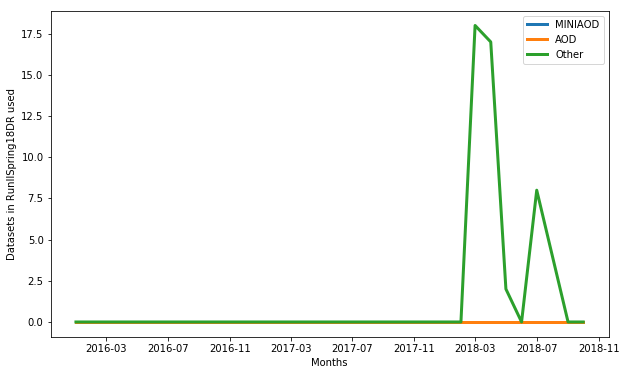

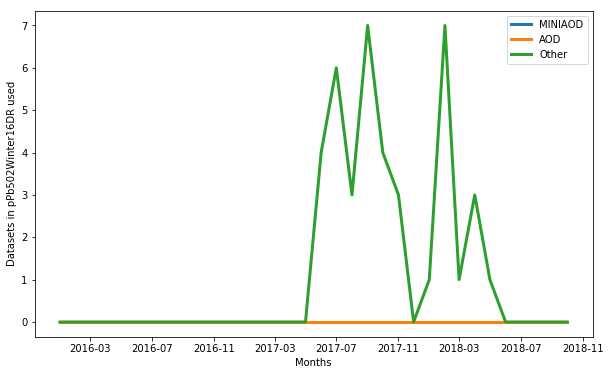

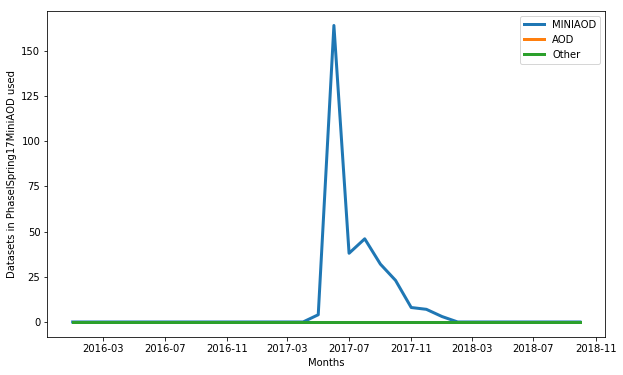

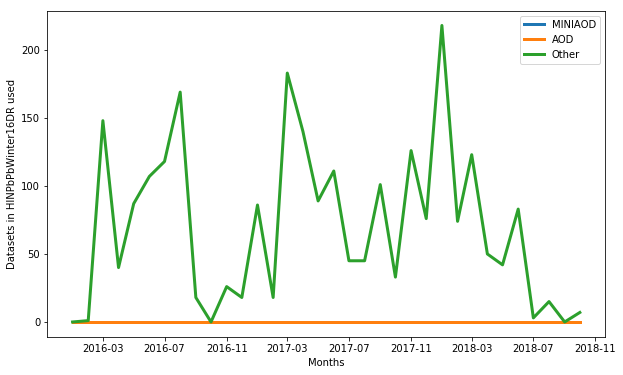

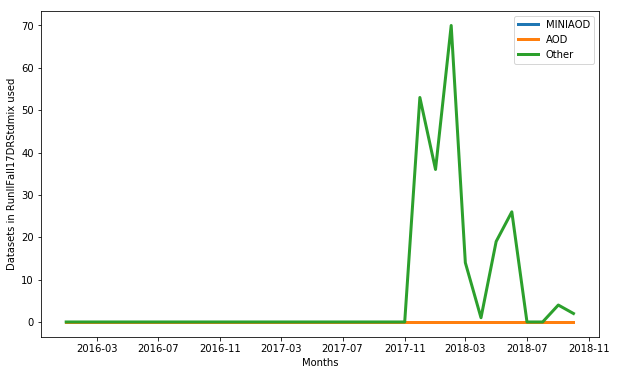

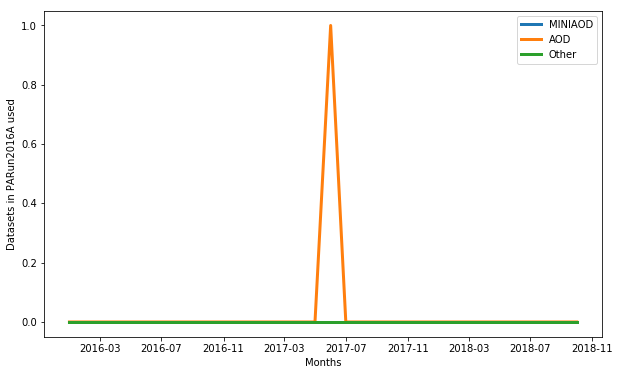

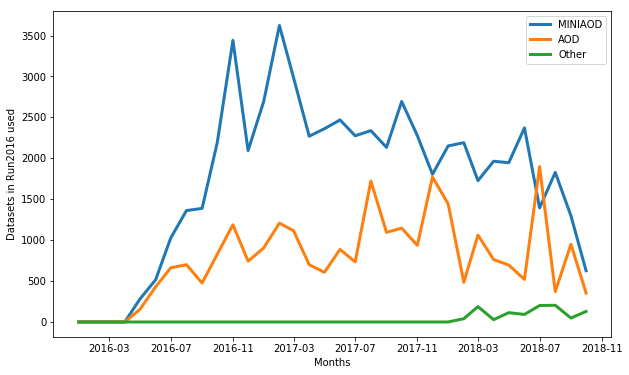

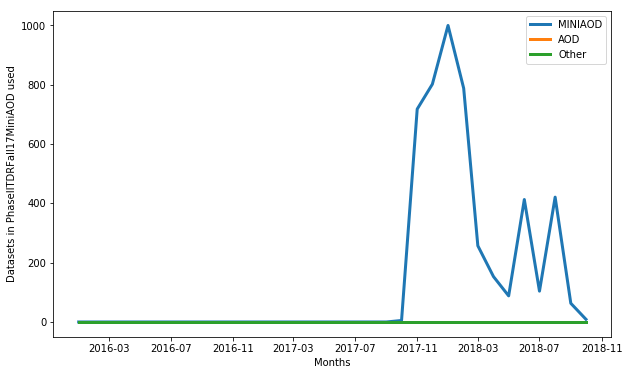

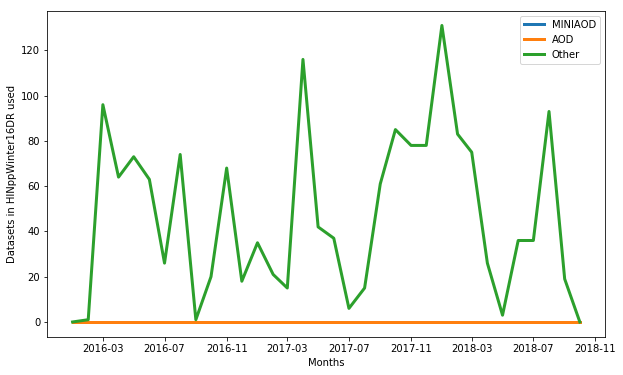

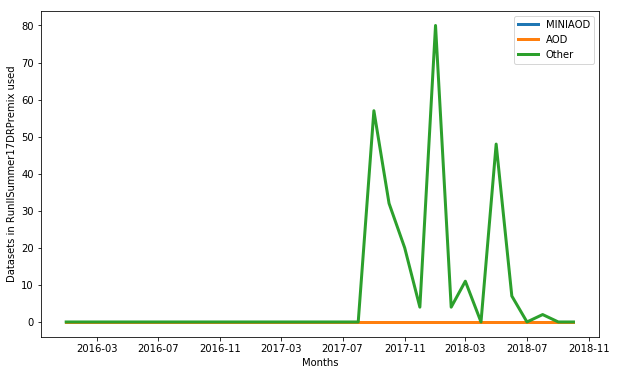

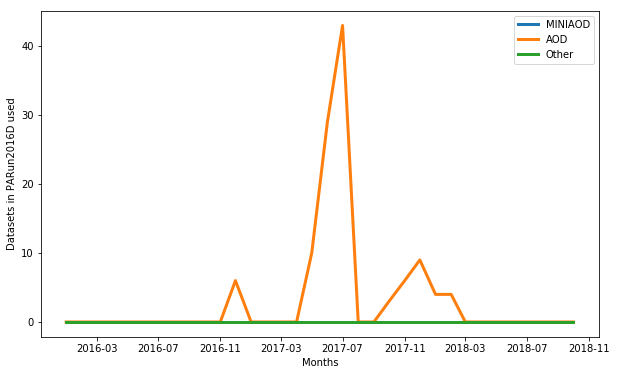

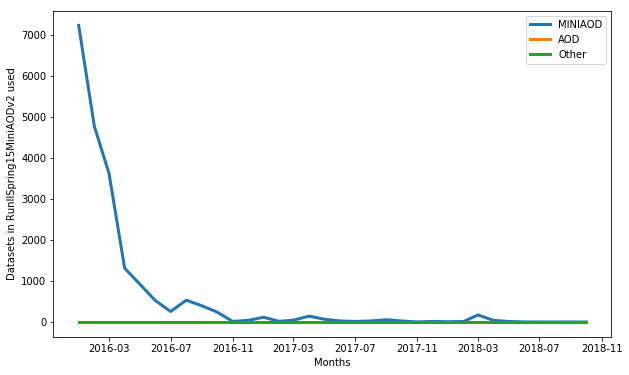

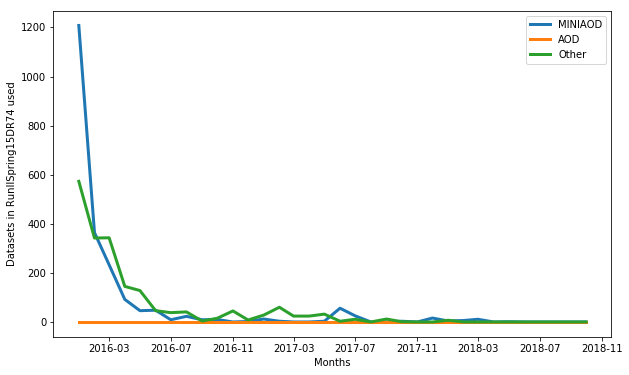

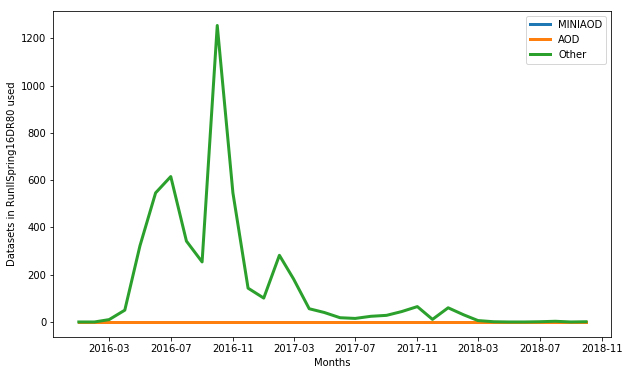

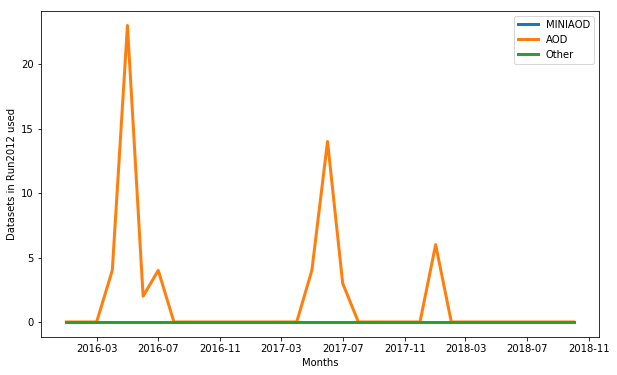

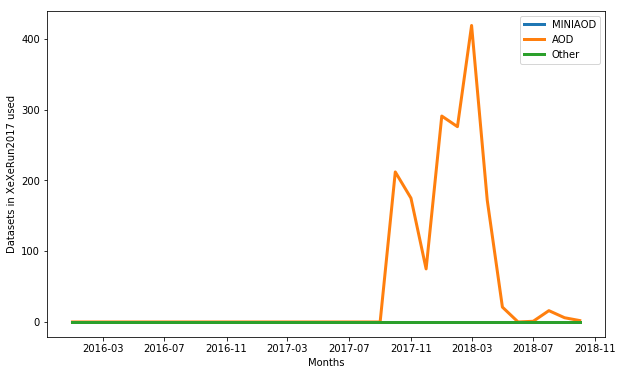

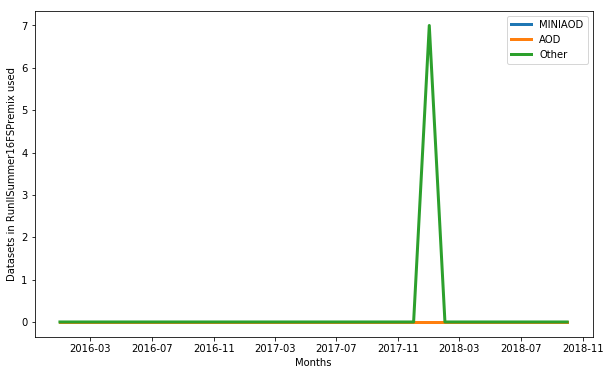

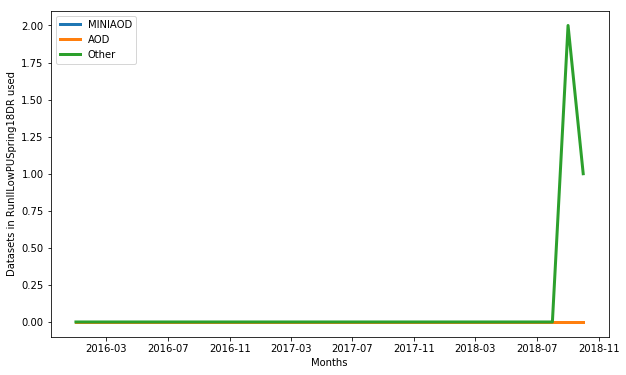

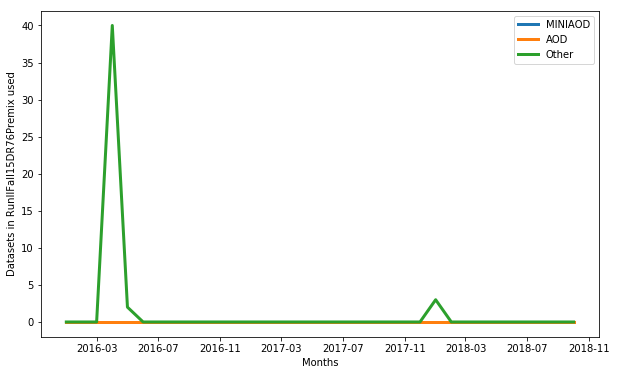

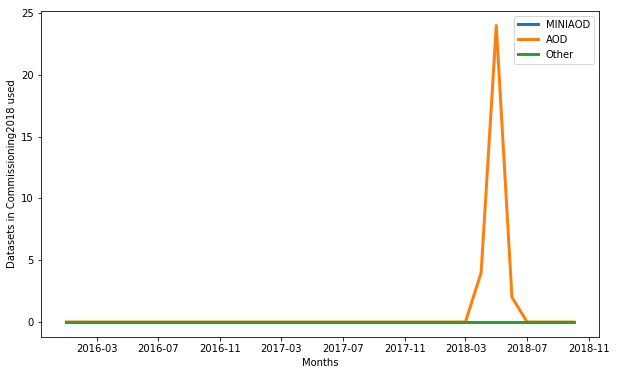

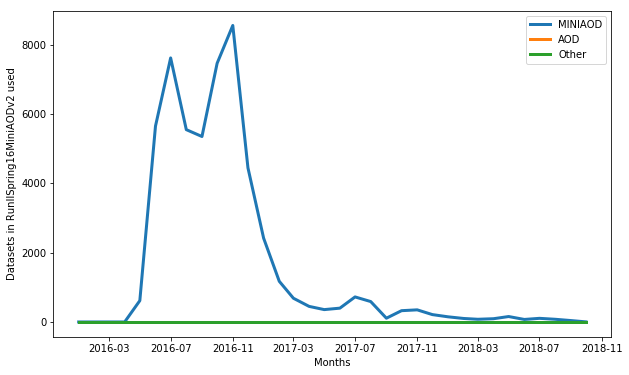

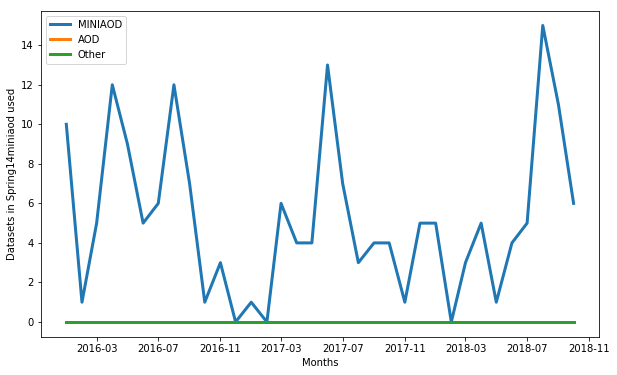

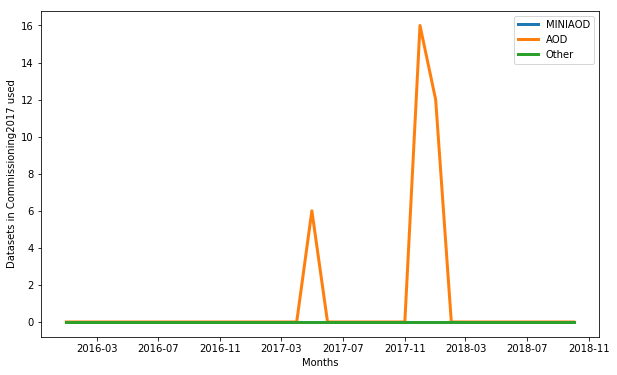

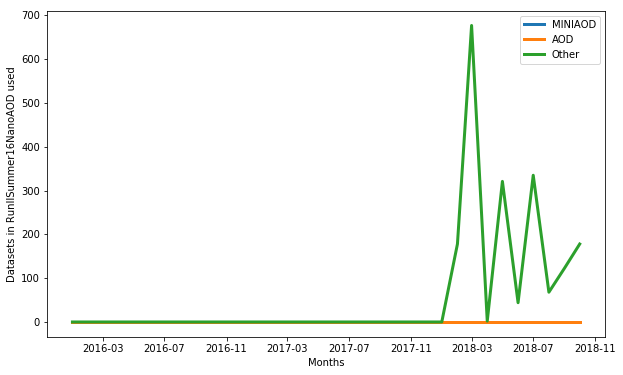

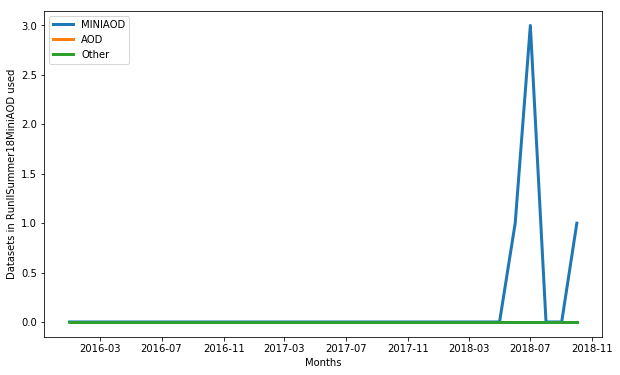

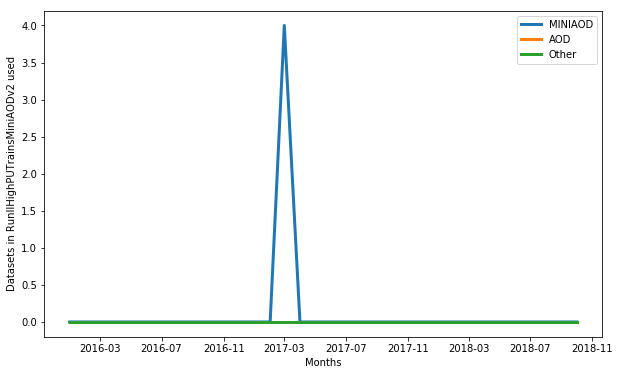

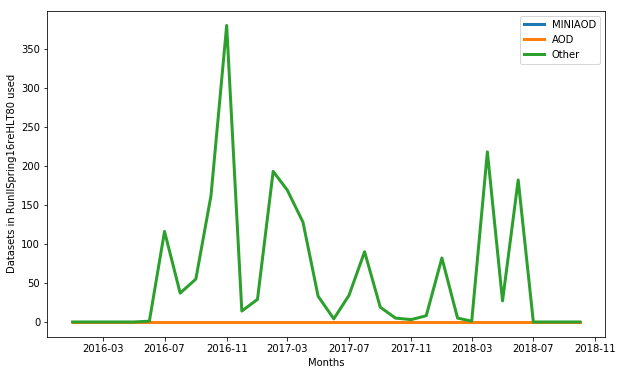

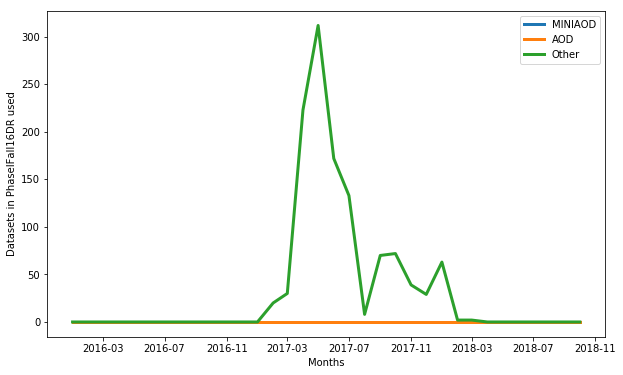

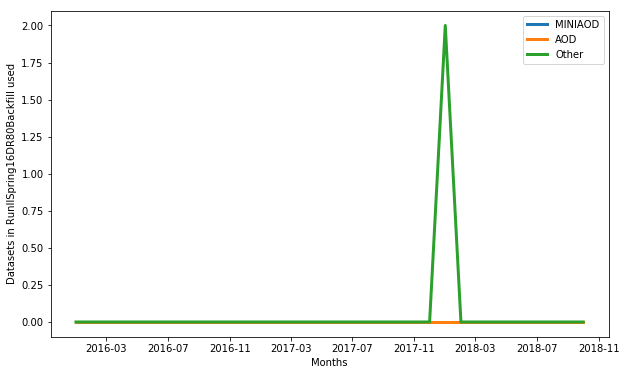

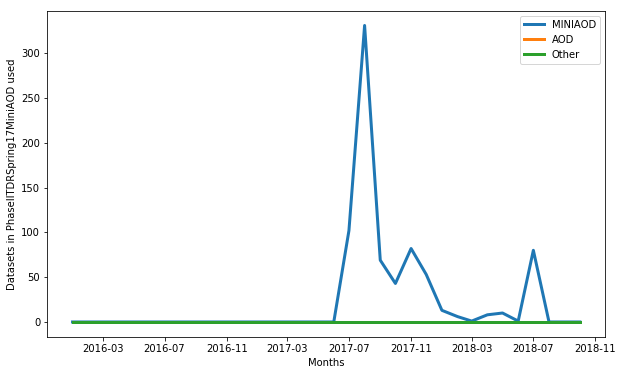

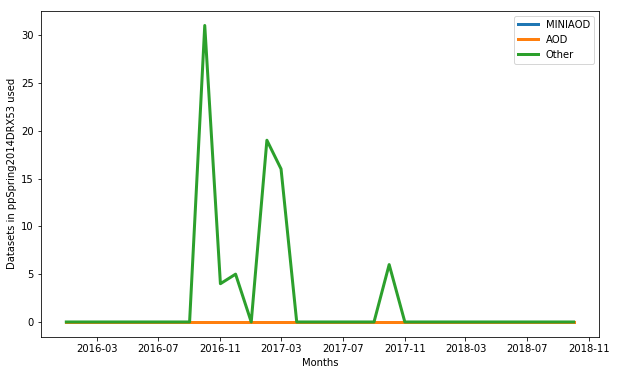

In [56]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 10, 6

nF=100
for camp in campaigns:
    pylab.figure(nF)
    pylab.plot(months,campaign_hists_mini[camp],linewidth=3)
    pylab.plot(months,campaign_hists_aod[camp],linewidth=3)
    pylab.plot(months,campaign_hists_other[camp],linewidth=3)
    pylab.xlabel('Months')
    pylab.ylabel('Datasets*Days in '+camp+' used')
    pylab.legend(['MINIAOD','AOD','Other'],loc='best')
    nF+=1

